# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


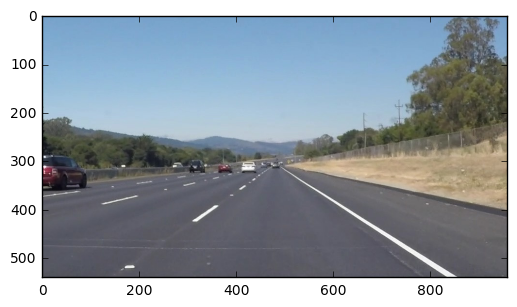

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [109]:
import math
import numpy as np


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def hsv_trans(img):
    """Applies the HSV transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def set_global():
    global g_xmin_l,g_xmax_l,g_xmin_r,g_xmax_r,g_ymin,g_ymax
    g_xmin_l = 0
    g_xmax_l = 0
    g_xmin_r = 0
    g_xmax_r = 0
    g_ymin = 0
    g_ymax = 0
    
"""
So the intercept is always where a line crosses the y-axis, even if the line does not physically crosses the y-axis, like in your image above. But if you would extrapolate all those 4 lines to infinity they will cross the y-axis somewhere, and that is your intercept per line.
The average intercept of those 4 lines above are all around 0 - because that is where the lines would cross the y-axis.
In your case if we just take 2 lines for example we would have something like: y = 0.5x + 0.05 and y = 0.4 - 0.01; the average line would be y = 0.45 + 0.02.
Next step would only be finding the max and min values where you want to plot this line
"""
# https://carnd-forums.udacity.com/questions/4784445/answers/22682799

def draw_lines(img, lines, color=[0, 255, 0], thickness=5):
    global g_xmin_l,g_xmax_l,g_xmin_r,g_xmax_r,g_ymin,g_ymax

    avg_r_int = []
    avg_r_slope = []   
    avg_l_int = []
    avg_l_slope = []
    ymin = 999
    ymax = -999
    for line in lines:
        for x1,y1,x2,y2 in line:
            m,b = np.polyfit([x1,x2],[y1,y2],1)
            # if the slope is positive, the line is in the right part
            if m > 0.15 and m < 5.:
                cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color = [255,0,0], thickness=5)
                avg_r_slope.append(m)
                avg_r_int.append(b)
            elif m > -5. and m < -0.15:
                cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color = [0,0,255], thickness=5)
                avg_l_slope.append(m)
                avg_l_int.append(b)
            
            # finding maximum & minimum of y
            ymin = min(y1,y2,ymin)
            ymax = max(y1,y2,ymax)
    
    # compute the average of intercept and slope
    r_int = np.mean(avg_r_int)
    r_slope = np.mean(avg_r_slope)
    
    l_int = np.mean(avg_l_int)
    l_slope = np.mean(avg_l_slope)
    
    # given the average_of_intercept, average_of_slope, maximum_of_y, minimum_of_y, compute the Xs
    xmin_r = (ymin-r_int)/r_slope
    xmax_r = (ymax-r_int)/r_slope
    
    xmin_l = (ymin-l_int)/l_slope
    xmax_l = (ymax-l_int)/l_slope
    
    # First Order filtering
    alp = 0.6
    
    # if this is the first time, then there is no previous value, set alp to 1 
    if g_xmin_r == 0 and g_xmax_r == 0 and g_xmin_l == 0 and g_xmax_l == 0 and g_ymax == 0 and g_ymin == 0:
        alp = 1
    xmin_r = alp*xmin_r + (1-alp)*g_xmin_r
    xmax_r = alp*xmax_r + (1-alp)*g_xmax_r
    
    xmin_l = alp*xmin_l + (1-alp)*g_xmin_l
    xmax_l = alp*xmax_l + (1-alp)*g_xmax_l
    
    ymax = alp*ymax + (1-alp)*g_ymax
    ymin = alp*ymin + (1-alp)*g_ymin
    
    # plot
    try:
        cv2.line(img, (int(xmin_r), int(ymin)), (int(xmax_r), int(ymax)), color = color, thickness=7)
        cv2.line(img, (int(xmin_l), int(ymin)), (int(xmax_l), int(ymax)), color = color, thickness=7)
    except ValueError:
        # if can't detect the line, use the value from previous frame
        cv2.line(img, (int(g_xmin_l), int(g_ymin)), (int(g_xmax_l), int(g_ymax)), color = color, thickness=7)
        cv2.line(img, (int(g_xmin_r), int(g_ymin)), (int(g_xmax_r), int(g_ymax)), color = color, thickness=7)
        if np.isnan(l_slope) == True:
            print("can't detect left side")
        elif np.isnan(r_slope) == True:
            print("can't detect right side")
        return
    
    # setting up the global variables
    g_xmin_r = xmin_r
    g_xmax_r = xmax_r
    
    g_xmin_l = xmin_l
    g_xmax_l = xmax_l
    
    g_ymax = ymax
    g_ymin = ymin
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def size_to_roi(shape):
    """
    `shape` is the dimension of an image
    """
    size_y,size_x,_ = shape
    lo_left = (int(size_x*0.1),size_y)
    up_left = (int(size_x*0.425),int(size_y*0.60))
    up_right = (int(size_x*0.575),int(size_y*0.60))
    lo_right = (int(size_x*0.95),size_y)
    return lo_left, up_left, up_right, lo_right

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [8]:
roi_mask

array([[ 96, 540],
       [384, 324],
       [624, 324],
       [912, 540]])

In [16]:
cv2.THRESH_OTSU

8

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


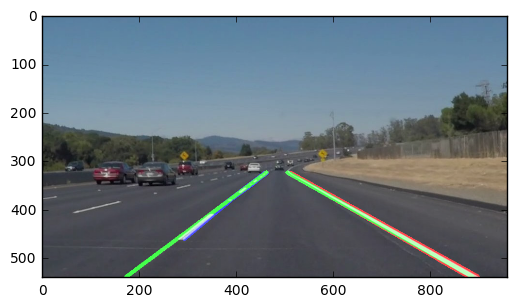

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


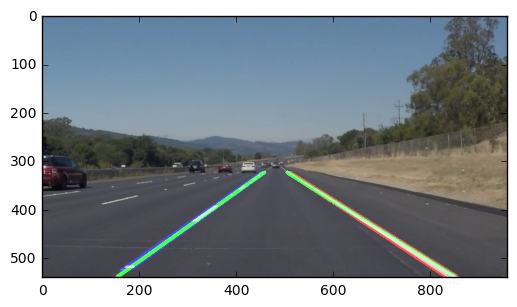

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


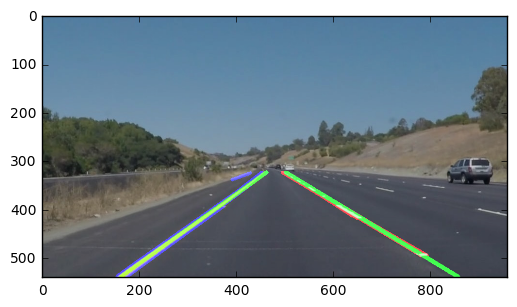

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


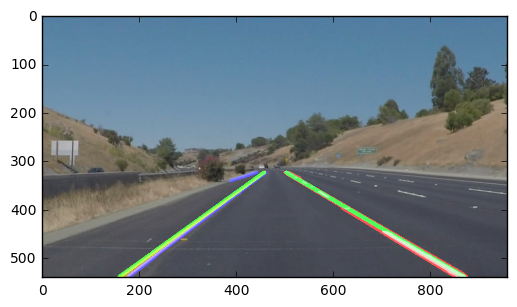

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


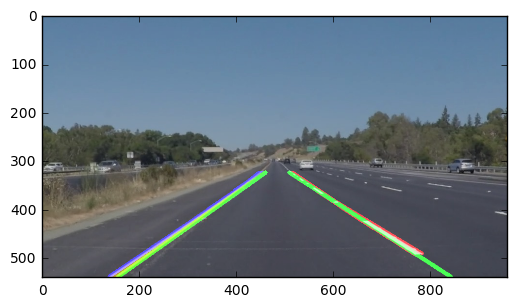

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


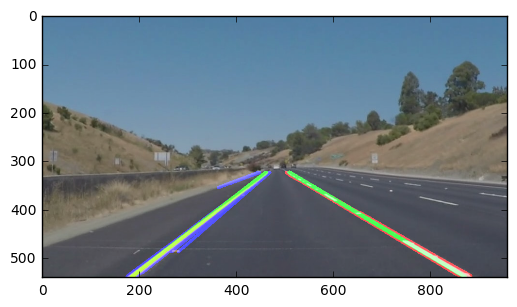

In [74]:
import os
set_global()
for f in os.listdir("test_images/")[:]:
    image = mpimg.imread('test_images/{}'.format(f))
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    gray = grayscale(image)
    gauss_cg = gaussian_blur(gray,3)
    high_thresh, thresh_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5*high_thresh
    cg = canny(gauss_cg,low_thresh,high_thresh)
    gauss_cg = gaussian_blur(cg,13)
    lo_left, up_left, up_right, lo_right = size_to_roi(image.shape)
    roi_mask = np.array([lo_left,up_left,up_right,lo_right],np.int32)
    roi_gcg = region_of_interest(cg,[roi_mask])
    
    roi_visualize = region_of_interest(image,[roi_mask])
    
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 1000 # maximum gap in pixels between connectable line segments
    
    hlines = hough_lines(roi_gcg,rho,theta,threshold,min_line_length,max_line_gap)
    h_im = weighted_img(hlines, image)

    plt.imshow(h_im, cmap='gray')
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image_rgb(image):  
    gray = grayscale(image)
    gauss_cg = gaussian_blur(gray,3)
    cg = canny(gauss_cg,200,250)
    gauss_cg = gaussian_blur(cg,13)

    lo_left, up_left, up_right, lo_right = size_to_roi(image.shape)
    roi_mask = np.array([lo_left,up_left,up_right,lo_right],np.int32)
    roi_gcg = region_of_interest(cg,[roi_mask])

    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 1000 # maximum gap in pixels between connectable line segments
    
    hlines = hough_lines(roi_gcg,rho,theta,threshold,min_line_length,max_line_gap)
    h_im = weighted_img(hlines, image)
   
    return h_im

In [110]:
def process_image_hsv(image):
    hsv = hsv_trans(image)
    lower_yellow_white = np.array([0,0,195])
    upper_yellow_white = np.array([150,255,255])

    mask = cv2.inRange(hsv, lower_yellow_white, upper_yellow_white)
    res = cv2.bitwise_and(image,image, mask= mask)
    gray = cv2.cvtColor(res, cv2.COLOR_HSV2RGB)

    gray = grayscale(gray)
    high_thresh, thresh_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5*high_thresh
    cg = canny(gray,low_thresh,high_thresh)
    gauss_cg = gaussian_blur(cg,5)

    lo_left, up_left, up_right, lo_right = size_to_roi(image.shape)
    roi_mask = np.array([lo_left,up_left,up_right,lo_right],np.int32)
    roi_gcg = region_of_interest(cg,[roi_mask])
    
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 80 # maximum gap in pixels between connectable line segments
    
    hlines = hough_lines(roi_gcg,rho,theta,threshold,min_line_length,max_line_gap)
    h_im = weighted_img(hlines, image)
    
    return h_im

Let's try the one with the solid white lane on the right first ...

In [111]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
set_global()
white_clip = clip1.fl_image(process_image_hsv) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



100%|███████████████████████████████████████▊| 221/222 [00:30<00:00,  8.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 33 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [112]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
set_global()
yellow_clip = clip2.fl_image(process_image_hsv)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [114]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Reflections Thoughts
My algorithm basically is that
- use HSV color spacefinding all lane lines
- group left/right lanes together
- filter out the line that its slope is too low
- for each side of lane lines do: 
 - finding the average slope & intercept, find ymax, find ymin
 - given avg of slope&int, ymax,ymin - calculate new Xs
 - plot the line accordingly
 
I can imagine possibilities of improving my algorithm here
- investigating on how to choose proper HSV value to get yellow&white color even in the three shadow
- adjusting proper Hough parameters (trial&error)
- to extrapolate the line, but not the straight line, so that it is able to run on curvy lanes

Where my algorithm is likely to fail
- in sense of dynamic light& color
- shaky camera & camera is not centered
- at night 
- curvy lane lines

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
set_global()
challenge_clip = clip2.fl_image(process_image_hsv)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Script for extract the frame of challenge video

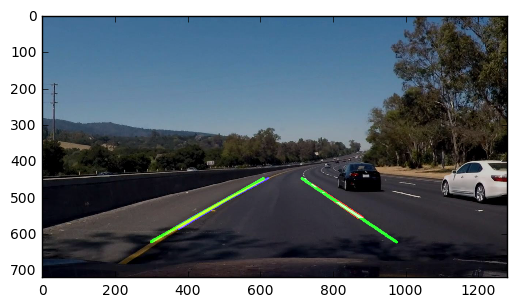

In [87]:
import scipy.misc
i = (06.5)
scipy.misc.imsave('challenge_snap\\challenge_snap{}.jpg'.format(i), clip2.get_frame(i))
image = mpimg.imread('challenge_snap\\challenge_snap{}.jpg'.format(i))

plt.imshow(process_image_hsv(image))
plt.show()

# Slider for setting the low&up boudaries

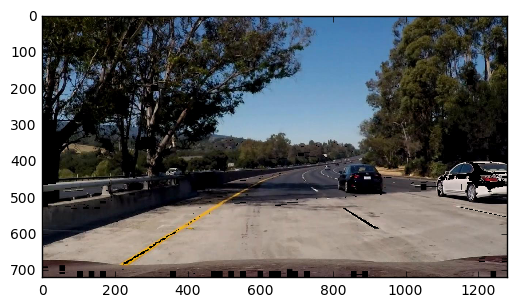

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, IntSlider

h_slider = IntSlider(min=0, max=255, step=1, value=1)
s_slider = IntSlider(min=0, max=255, step=1, value=1)
v_slider = IntSlider(min=0, max=255, step=1, value=1)

h_slider2 = IntSlider(min=0, max=255, step=1, value=1)
s_slider2 = IntSlider(min=0, max=255, step=1, value=1)
v_slider2 = IntSlider(min=0, max=255, step=1, value=1)

# decorate the plot function with an environment from the UIs:
@interact(h=h_slider,s=s_slider,v=v_slider,h2=h_slider2,s2=s_slider2,v2=v_slider2)
def plot(h,s,v, h2,s2,v2):
    set_global()
    image = mpimg.imread('challenge_snap/{}'.format('challenge_snap5.65.jpg'))
    hsv = hsv_trans(image)
    lower_blue = np.array([h,s,v])
    upper_blue = np.array([h2,s2,v2])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    res = cv2.bitwise_and(image,image, mask= mask)
    gray = cv2.cvtColor(res, cv2.COLOR_HSV2RGB)

    gray = grayscale(gray)
    cg = canny(gray,100,250)
    plt.imshow(res,cmap='gray')
    plt.show()